## Переобучение нейронных сетей и борьба с ним

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/girafe_ai

In [1]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________

def args_and_kwargs(*args, **kwargs):
    return args, kwargs

def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_name, params = layer_str.split("(", 1)
        layer_info = {"type": layer_name.strip()}
        params_template = layer_str.replace(layer_name, "args_and_kwargs")

        param_dict = {}
        if len(params):
            args, kwargs = eval(params_template)
            if len(args) or len(kwargs):
                param_dict["args"] = args
                for name, value in kwargs.items():
                    param_dict[name] = value
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict

# __________end of block__________

In [16]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()

    model.train(False)
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [4]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-25 12:42:06--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-25 12:42:06--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

In [5]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

### Задача №1 (уже решённая): Создание и обучение модели (Separation)
Вы уже решали эту задачу ранее, так что сейчас просто воспроизведите своё решение. Оно понадобится вам в дальнейших шагах.
__Ваша первая задача всё та же: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__


In [6]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.77MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.4MB/s]


Text(0.5, 1.0, 'Image label: 2')

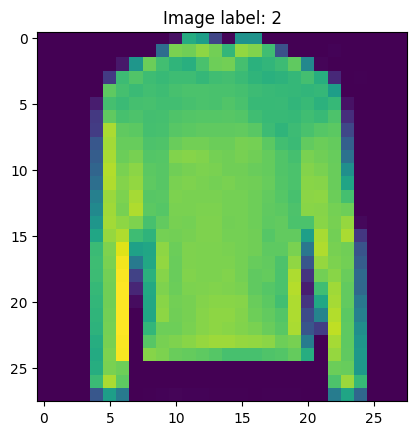

In [7]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [ ]:
class convmodelover(nn.Module):
  def __init__(self):
      super().__init__()
      self.norm1=nn.BatchNorm2d(1)
      self.conv2=nn.Conv2d(1,5,3)
      self.conv3=nn.Conv2d(5,5,3)
      self.conv4=nn.Conv2d(5,5,3)
      self.relu=nn.ReLU()
      self.conv5=nn.Conv2d(5,5,3)
      self.maxp=nn.MaxPool2d(2)
      self.fc1=nn.Linear(405,405)
      self.fc2=nn.Linear(405,405)
      self.fc3=nn.Linear(405,10)
      self.flatten=nn.Flatten()


  def forward(self, x):
      x=self.norm1(x)
      x=self.fc3(self.relu(self.fc2(self.relu(self.fc1(self.relu(self.flatten(self.conv5(self.maxp(self.relu(self.conv4(self.relu(self.conv3(self.relu(self.conv2(x)))))))))))))))
      return x


model_task_1=convmodelover()
model_task_1.to(device)

convmodelover(
  (norm1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (conv5): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (maxp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=405, out_features=405, bias=True)
  (fc2): Linear(in_features=405, out_features=405, bias=True)
  (fc3): Linear(in_features=405, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
def train(model, loss_f, opt, train_data_loader, test_data_loader, num_epoch):
  for epoch in range(num_epoch):
    train_history=[]
    test_history=[]

    for image, label in tqdm(train_data_loader):
      temp=[]
      temp_test=[]

      opt.zero_grad()
      label_predicted=model(image.to(device))
      loss=loss_f(label_predicted, label.to(device))
      loss.backward()
      opt.step()
      temp.append(loss.item())
    train_history.append(np.mean(temp))

    with torch.no_grad():
      for image_test, label_test in tqdm(test_data_loader):
        label_predicted_test=model(image_test.to(device))
        loss_test=loss_f(label_predicted_test, label_test.to(device))
        temp_test.append(loss_test.item())
      test_history.append(np.mean(temp_test))

    print(train_history[-1])
    print(test_history[-1])
    print(epoch+1)
    print('\n')
  return model

loss_f=nn.CrossEntropyLoss()
opt=torch.optim.Adam(model_task_1.parameters(),lr=0.003)
num_epoch=5
model_task_1=train(model_task_1, loss_f, opt, train_data_loader, test_data_loader,num_epoch)

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.4520755708217621
0.42992549920424866
1




  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.38275662064552307
0.3308624610447655
2




  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.11283223330974579
0.31783336589035516
3




  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.3967097997665405
0.3352678044321248
4




  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.14851383864879608
0.30991075982967503
5




Не забудьте перенести модель на выбранный `device`!

Локальные тесты для проверки вашей модели доступны ниже:

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [ ]:
# your code here

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [ ]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.91


In [ ]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.8861


Проверка, что необходимые пороги пройдены:

In [ ]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_task_1.json`")
# __________end of block__________

File saved to `submission_dict_task_1.json`


### Задача №2: Переобучение (Initiation)
Продолжим работу с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Теперь ваша задача продемонстрировать переобучение модели на обучающей выборке. Достаточно показать, что точность классификации (не только функция потерь!) на тестовой выборке значительно отстает от обучающей.

Обращаем ваше внимание, в задаче №3 вам придется починить данную модель (минимизировать эффект переобучения) с помощью механизмов регуляризации, поэтому не переусердствуйте!

__Ваша вторая задача: реализовать используя пайплан обучения модели продемонстрировать переобучения модели на обучающей выборке.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_2` для хранение модели во второй задаче.

Не используйте `Dropout` и `BatchNorm` в этой задаче

In [ ]:
class convmodelover(nn.Module):
  def __init__(self):
      super().__init__()
      self.norm1=nn.BatchNorm2d(1)
      self.conv2=nn.Conv2d(1,5,3)
      self.conv3=nn.Conv2d(5,5,3)
      self.conv4=nn.Conv2d(5,5,3)
      self.relu=nn.ReLU()
      self.conv5=nn.Conv2d(5,5,3)
      self.maxp=nn.MaxPool2d(2)
      self.fc1=nn.Linear(405,405)
      self.fc2=nn.Linear(405,405)
      self.fc3=nn.Linear(405,10)
      self.flatten=nn.Flatten()


  def forward(self, x):
      x=self.norm1(x)
      x=self.fc3(self.relu(self.fc2(self.relu(self.fc1(self.relu(self.flatten(self.conv5(self.maxp(self.relu(self.conv4(self.relu(self.conv3(self.relu(self.conv2(x)))))))))))))))
      return x


model_task_2=convmodelover()
model_task_2.to(device)

convmodelover(
  (norm1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (conv5): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (maxp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=405, out_features=405, bias=True)
  (fc2): Linear(in_features=405, out_features=405, bias=True)
  (fc3): Linear(in_features=405, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
def train(model, loss_f, opt, train_data_loader, test_data_loader, num_epoch):
  for epoch in range(num_epoch):
    train_history=[]
    test_history=[]

    for image, label in tqdm(train_data_loader):
      temp=[]
      temp_test=[]

      opt.zero_grad()
      label_predicted=model(image.to(device))
      loss=loss_f(label_predicted, label.to(device))
      loss.backward()
      opt.step()
      temp.append(loss.item())
    train_history.append(np.mean(temp))

    with torch.no_grad():
      for image_test, label_test in tqdm(test_data_loader):
        label_predicted_test=model(image_test.to(device))
        loss_test=loss_f(label_predicted_test, label_test.to(device))
        temp_test.append(loss_test.item())
      test_history.append(np.mean(temp_test))

    print(train_history[-1])
    print(test_history[-1])
    print(epoch+1)
    print('\n')
  return model

loss_f=nn.CrossEntropyLoss()
opt=torch.optim.Adam(model_task_2.parameters(),lr=0.003)
num_epoch=2
model_task_2=train(model_task_2, loss_f, opt, train_data_loader, test_data_loader,num_epoch)

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.11140771210193634
0.4252350127842194
1




  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.14597009122371674
0.34091803304160745
2




Проверка архитектуры:

In [ ]:
# do not change the code in the block below
# __________start of block__________
layers_task_2 = []
for element in parse_pytorch_model(str(model_task_2)).get("layers", []):
    layer_name = element["layer"]["type"]
    assert "dropout" not in layer_name.lower(), "Do not use Dropout in Task 2!"
    assert "batchnorm" not in layer_name.lower(), "Do not use BatchNorm in Task 2!"
    layers_task_2.append(layer_name)
# __________end of block__________

Оценим качество классификации:

In [ ]:
train_acc_task_2 = get_accuracy(model_task_2, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_2:3.5}")

Neural network accuracy on train set: 0.938


In [ ]:
test_acc_task_2 = get_accuracy(model_task_2, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_2:3.5}")

Neural network accuracy on test set: 0.8943


Проверка, что переобучение присутствует:

In [ ]:
assert train_acc_task_2 >= test_acc_task_2, "Train accuracy must be higher than task accuracy"
assert train_acc_task_2 >= 0.88, "Train accuracy must be higher than 0.88"
assert (
    train_acc_task_2 - test_acc_task_2 >= 0.04
), "Test accuracy should be at least 0.04 lower that train."

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_2`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задачи №1. Если их там нет, загрузите их из сохраненного файла в переменную перед запуском следующей ячейки.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_2": parse_pytorch_model(str(model_task_2)),
    }
)

with open("submission_dict_tasks_1_and_2.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_tasks_1_and_2.json`")
# __________end of block__________

File saved to `submission_dict_tasks_1_and_2.json`


### Задача №3: Исправление модели (Return)
Все так же работаем с [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Наконец, ваша задача исправить ~~ошибки прошлого~~ переобучение модели, построенной в задаче 2. Достаточно добиться расхождения между точностью классификации на обучающей и тестовой выборках не превышающего 0.015 (т.е. полутора процентов).

Обращаем ваше внимание, архитектура модели в задаче №3 не должна существенно отличаться от задачи №2! Вы можете использовать Batchnorm, Dropout, уменьшить размерность промежуточных представлений, обратиться к аугментации данных, но вы не можете использовать меньшее количество слоёв.

__Ваша третья и финальная задача: исправить модель и/или процесс обучения, дабы справиться с переобучением.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_3` для хранение модели во второй задаче.

Также код ниже будет обращаться к переменной `layers_task_2`, инициализируйте её, если она не определена.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert (
    layers_task_2 is not None
), "Initializa layers_task_2 vairable which contains list of layers in task 2 model"
# __________end of block__________

In [12]:
class convmodelreturn(nn.Module):
  def __init__(self):
      super().__init__()
      self.norm1=nn.BatchNorm2d(1)
      self.conv2=nn.Conv2d(1,3,3)
      self.norm2=nn.BatchNorm2d(3)
      self.conv3=nn.Conv2d(3,5,3)
      self.norm3=nn.BatchNorm2d(5)
      self.conv4=nn.Conv2d(5,7,3)
      self.norm4=nn.BatchNorm2d(7)
      self.relu=nn.ReLU()
      self.conv5=nn.Conv2d(7,9,3)
      self.norm5=nn.BatchNorm1d(225)
      self.maxp=nn.MaxPool2d(3)
      self.fc1=nn.Linear(225,100)
      self.norm6=torch.nn.BatchNorm1d(100)
      self.fc2=nn.Linear(100,50)
      self.norm7=torch.nn.BatchNorm1d(50)
      self.fc3=nn.Linear(50,10)
      self.flatten=nn.Flatten()
      self.dropout1d=nn.Dropout(p=0.2, inplace=False)
      self.dropout2d=nn.Dropout(p=0.2, inplace=False)


  def forward(self, x):
      x=self.norm1(x)
      x=self.fc3(self.norm7(self.dropout1d(self.relu(self.fc2(self.norm6(self.dropout1d(self.relu(self.fc1(self.norm5(self.dropout2d(self.relu(self.flatten(self.conv5(self.norm4(self.dropout2d(self.maxp(self.relu(self.conv4(self.norm3(self.dropout2d(self.relu(self.conv3(self.norm2(self.dropout2d(self.relu(self.conv2(x)))))))))))))))))))))))))))
      return x


model_task_3=convmodelreturn()
model_task_3.to(device)

convmodelreturn(
  (norm1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (norm3): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1))
  (norm4): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv5): Conv2d(7, 9, kernel_size=(3, 3), stride=(1, 1))
  (norm5): BatchNorm1d(225, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxp): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=225, out_features=100, bias=True)
  (norm6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_fe

In [19]:
def train(model, loss_f, opt, train_data_loader, test_data_loader, num_epoch):
  for epoch in range(num_epoch):
    train_history=[]
    test_history=[]

    model.train(True)
    for image, label in tqdm(train_data_loader):
      temp=[]
      temp_test=[]

      opt.zero_grad()
      label_predicted=model(image.to(device))
      loss=loss_f(label_predicted, label.to(device))
      loss.backward()
      opt.step()
      temp.append(loss.item())
    train_history.append(np.mean(temp))

    model.train(False)
    with torch.no_grad():
      for image_test, label_test in tqdm(test_data_loader):
        label_predicted_test=model(image_test.to(device))
        loss_test=loss_f(label_predicted_test, label_test.to(device))
        temp_test.append(loss_test.item())
      test_history.append(np.mean(temp_test))

    print(train_history[-1])
    print(test_history[-1])
    print(epoch+1)
    print('\n')
  return model

loss_f=nn.CrossEntropyLoss()
opt=torch.optim.Adam(model_task_3.parameters(),lr=0.005)
num_epoch=5
model_task_3=train(model_task_3, loss_f, opt, train_data_loader, test_data_loader,num_epoch)

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.2895006239414215
0.3657506258009722
1




  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.4821004867553711
0.36277703821849516
2




  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.3123576045036316
0.40100368519370166
3




  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.6192136406898499
0.3815646257263403
4




  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.2886684834957123
0.3648646312495009
5




Проверка архитектуры:

In [ ]:
# do not change the code in the block below
# __________start of block__________
layers_task_3 = []
for element in parse_pytorch_model(str(model_task_3)).get("layers", []):
    layer_name = element["layer"]["type"]
    layers_task_3.append(layer_name)


idx = 0
for model_3_layer in layers_task_3:
    model_2_layer = layers_task_2[idx]
    if "dropout" not in model_3_layer.lower() and "batchnorm" not in model_3_layer.lower():
        assert (
            model_3_layer == model_2_layer
        ), "Models in tasks 2 and 3 must share the architecture except for Dropout and BatchNorm!"
        idx += 1
# __________end of block__________

Оценим качество классификации:

In [21]:
train_acc_task_3 = get_accuracy(model_task_3, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_3:3.5}")

Neural network accuracy on train set: 0.87165


In [20]:
test_acc_task_3 = get_accuracy(model_task_3, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_3:3.5}")

Neural network accuracy on test set: 0.8626


Проверка, что переобучение присутствует:

In [ ]:
assert train_acc_task_3 >= 0.88, "Train accuracy must be higher than 0.88"
assert test_acc_task_3 >= 0.865, "Test accuracy must be higher than 0.865"
assert (
    train_acc_task_3 - test_acc_task_3 <= 0.015
), "Test accuracy should not be lower that train more than by 0.015"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_3`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задач №1 и №2. Если их там нет, загрузите их из сохраненных файлов перед запуском следующей ячейки.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_3": parse_pytorch_model(str(model_task_3)),
    }
)

with open("submission_dict_final.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_final.json`")
# __________end of block__________

File saved to `submission_dict_final.json`


### Сдача задания
Сдайте сгенерированные файлы в соответствующие задачи в соревновании, а именно:
* `submission_dict_tasks_1_and_2.json` в задачу Initiation
* `submission_dict_final.json` в задачу Return.


`submission_dict_task_1.json` сдавать не нужно, он уже был сдан ранее.

На этом задание завершено. Поздравляем!